In [48]:
!pip install spacy imbalanced-learn wordcloud
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import spacy
from nltk.corpus import stopwords
from wordcloud import WordCloud

nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 98.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [49]:
df = pd.read_csv('missing_persons_clean.csv')
df.head()

,name,description,long,lat,location
0,NamUs #UP4795 ME/C Case Number GC99-158 604UFMN,"date found: November 4, 1999location: Red Wing...",-92.541061,44.565821,POINT(-92.5410605 44.5658215)
1,NamUs #UP4804 ME/C Case Number 39918 849UFMN,"date found: July 20, 1977location: St. Paul, M...",-93.055401,44.941109,POINT(-93.0554009 44.9411089)
2,NamUS #UP4808 ME/C Case Number 00-1411 270UFMN,NaN,-93.194060,45.078014,POINT(-93.1940597 45.0780144)
3,NamUs #UP4796 ME/C Case Number GC07-39 102UFMN,"date found: March 26, 2007location: Treasure I...",-92.641182,44.635803,POINT(-92.6411819 44.6358033)
4,NamUs #UP6525 ME/C Case Number FC08-61 803UFMN,"date found: August 10, 2008location: Mabel, Mi...",-91.773434,43.520049,POINT(-91.7734337 43.5200495)


In [50]:
# Drop rows with missing descriptions
df = df[df['description'].notnull()].copy()

In [51]:
# Feature extraction
def infer_status(text):
    text = str(text).lower()
    found_keywords = [
        "body found", "remains found", "located deceased", "decomposed", "skeletal remains",
        "confirmed deceased", "discovered", "died", "autopsy", "murder", "deceased"
    ]
    missing_keywords = [
        "last seen", "still missing", "disappeared", "has not been found", "vanished",
        "unaccounted for", "runaway", "missing since", "has not been seen"
    ]
    if any(kw in text for kw in found_keywords):
        return "remains_found"
    elif any(kw in text for kw in missing_keywords):
        return "missing"
    else:
        return "unknown"

df['status'] = df['description'].apply(infer_status)
df['status'] = df['status'].astype('category')
df = df[df['status'].isin(['missing', 'remains_found'])]  # keep only known classes

# Race indicators
df['is_white'] = df['description'].str.contains('White|Caucasian', case=False, na=False).astype(int)
df['is_black'] = df['description'].str.contains('Black|African', case=False, na=False).astype(int)
df['is_mixed'] = df['description'].str.contains(',', na=False).astype(int)

# Extract numeric age from age_est if available
def extract_age(age_str):
    if pd.isnull(age_str):
        return np.nan, np.nan
    age_match = re.findall(r'\d{1,2}', age_str)
    if len(age_match) == 2:
        return int(age_match[0]), int(age_match[1])
    elif len(age_match) == 1:
        return int(age_match[0]), int(age_match[0])
    else:
        return np.nan, np.nan

df[['age_low', 'age_high']] = df['description'].apply(lambda x: pd.Series(extract_age(x)))

# EDA

In [52]:
# Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5508 entries, 1 to 17306
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   name         5508 non-null   object  
 1   description  5508 non-null   object  
 2   long         5508 non-null   float64 
 3   lat          5508 non-null   float64 
 4   location     5508 non-null   object  
 5   status       5508 non-null   category
 6   is_white     5508 non-null   int64   
 7   is_black     5508 non-null   int64   
 8   is_mixed     5508 non-null   int64   
 9   age_low      47 non-null     float64 
 10  age_high     47 non-null     float64 
dtypes: category(1), float64(4), int64(3), object(3)
memory usage: 478.9+ KB


In [53]:
# Missing values
df.isnull().sum()

,0
name,0
description,0
long,0
lat,0
location,0
status,0
is_white,0
is_black,0
is_mixed,0
age_low,5461


In [54]:
# Stats
df.describe(include = 'all')

,name,description,long,lat,location,status,is_white,is_black,is_mixed,age_low,age_high
count,5508,5508,5508.000000,5508.000000,5508,5508,5508.000000,5508.000000,5508.000000,47.000000,47.000000
unique,5488,5499,NaN,NaN,5462,2,NaN,NaN,NaN,NaN,NaN
top,1979 NamUs UP # 10083 18-30 y/o Hispanic Male,"date found: June 25, 1915location: Niagara, ND...",NaN,NaN,POINT(-118.214052 34.0603504),missing,NaN,NaN,NaN,NaN,NaN
freq,2,4,NaN,NaN,3,2944,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,-82.371707,36.735920,NaN,NaN,0.472222,0.213326,0.963145,52.787234,46.680851
std,NaN,NaN,47.264275,12.514024,NaN,NaN,0.499273,0.409693,0.188424,22.114265,27.505024
min,NaN,NaN,-176.617836,-45.881763,NaN,NaN,0.000000,0.000000,0.000000,1.000000,0.000000
25%,NaN,NaN,-111.824758,32.776490,NaN,NaN,0.000000,0.000000,1.000000,31.000000,23.000000
50%,NaN,NaN,-87.872408,36.956183,NaN,NaN,0.000000,0.000000,1.000000,69.000000,45.000000
75%,NaN,NaN,-79.179680,42.331792,NaN,NaN,1.000000,0.000000,1.000000,70.500000,71.000000


In [55]:
# Duplicates
df.duplicated().sum()

np.int64(0)

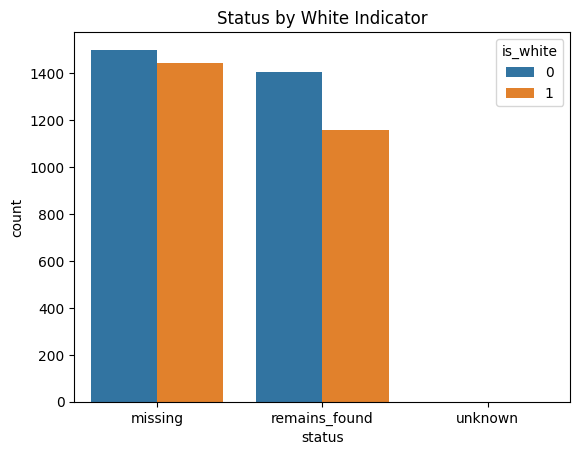

In [56]:
# Visualizing race effects on status
sns.countplot(data = df, x = 'status', hue = 'is_white')
plt.title('Status by White Indicator')
plt.show()

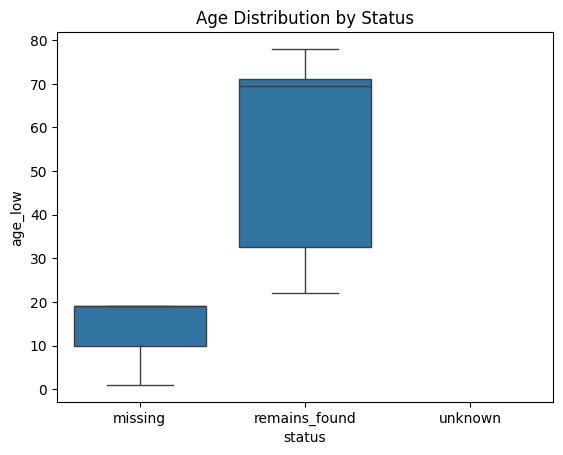

In [57]:
# Visualizing Age effects on Status
sns.boxplot(data = df, x = 'status', y = 'age_low')
plt.title('Age Distribution by Status')
plt.show()

## Predicting Status: supervised

In [59]:
features_structured = ['age_low', 'age_high', 'long', 'lat', 'is_white', 'is_black', 'is_mixed']

X_structured = df[features_structured]
X_text = df['description']
y = df['status']

# Impute missing age values with the mean
X_structured['age_low'] = X_structured['age_low'].fillna(X_structured['age_low'].mean())
X_structured['age_high'] = X_structured['age_high'].fillna(X_structured['age_high'].mean())


# Split data
X_str_train, X_str_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
    X_structured, X_text, y, stratify=y, test_size=0.3, random_state = 42
)

X_train_combined = pd.concat([X_txt_train.reset_index(drop=True), X_str_train.reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([X_txt_test.reset_index(drop=True), X_str_test.reset_index(drop=True)], axis=1)

# Pipeline
tfidf = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.9)
scaler = Pipeline([('scale', StandardScaler())])

preprocessor = ColumnTransformer([
    ('text', tfidf, 'description'),
    ('num', scaler, features_structured)
])

clf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(random_state=504))
])

# Oversample/Train
ros = RandomOverSampler(random_state=504)
X_balanced, y_balanced = ros.fit_resample(X_train_combined, y_train)

clf.fit(X_balanced, y_balanced)

/tmp/ipython-input-527267436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_structured['age_low'] = X_structured['age_low'].fillna(X_structured['age_low'].mean())
/tmp/ipython-input-527267436.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_structured['age_high'] = X_structured['age_high'].fillna(X_structured['age_high'].mean())


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  min_df=5,
                                                                  stop_words='english'),
                                                  'description'),
                                                 ('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['age_low', 'age_high',
                                                   'long', 'lat', 'is_white',
                                                   'is_black', 'is_mixed'])])),
                ('model', RandomForestClassifier(random_state=504))])

## Eval

In [60]:
y_pred = clf.predict(X_test_combined)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[857  27]
 [ 67 702]]
\nClassification Report:
               precision    recall  f1-score   support

      missing       0.93      0.97      0.95       884
remains_found       0.96      0.91      0.94       769

     accuracy                           0.94      1653
    macro avg       0.95      0.94      0.94      1653
 weighted avg       0.94      0.94      0.94      1653



## Keyword Importance

In [62]:
tfidf_vocab = clf.named_steps['prep'].transformers_[0][1].get_feature_names_out()
all_features = list(tfidf_vocab) + features_structured
importances = clf.named_steps['model'].feature_importances_
top_idx = np.argsort(importances)[-20:]

print("🔍 Top 20 Important Features (TF-IDF + Structured):")
for i in reversed(top_idx):
    print(f"{all_features[i]:<25} Importance: {importances[i]:.4f}")

🔍 Top 20 Important Features (TF-IDF + Structured):
nicknames                 Importance: 0.0854
est                       Importance: 0.0769
aliases                   Importance: 0.0719
seen                      Importance: 0.0617
unidentifiedpersons       Importance: 0.0361
lbsdescription            Importance: 0.0165
remains                   Importance: 0.0162
discovered                Importance: 0.0161
died                      Importance: 0.0153
body                      Importance: 0.0139
charleyproject            Importance: 0.0115
skeletal                  Importance: 0.0105
murder                    Importance: 0.0096
missingpersons            Importance: 0.0096
identifyus                Importance: 0.0095
deceased                  Importance: 0.0090
heard                     Importance: 0.0085
findthemissing            Importance: 0.0081
missing                   Importance: 0.0080
inches                    Importance: 0.0072
